In [1]:
import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms

import numpy as np

In [2]:
batch_size = 256
max_epochs = 100
patience = 10

device = "mps"

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

#batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_dataloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
class NeuralNetwork(nn.Module):
    def __init__(self, hidden_size=100):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(32*32*3, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [5]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, train_correct = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    
    train_loss /= size
    train_correct /=size

    return train_loss, train_correct

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, test_correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            test_correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= size
    test_correct /= size
    
    return test_loss, test_correct

In [6]:
class EarlyStopper:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [7]:
model = NeuralNetwork(hidden_size=50)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
early_stopper = EarlyStopper(patience=patience, min_delta=0)

tr1_loss, tr1_correct = [], []
te1_loss, te1_correct = [], []
for t in range(max_epochs):
    train_loss, train_correct = train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loss, test_correct = test_loop(test_dataloader, model, loss_fn)
    
    tr1_loss.append(train_loss), tr1_correct.append(train_correct)
    te1_loss.append(test_loss), te1_correct.append(test_correct)
    
    
    print(f"Epoch {t+1}: Train_accuracy: {(100*train_correct):>0.2f}%, Train_loss: {train_loss:>8f}, Test_accuracy: {(100*test_correct):>0.2f}%, Test_loss: {test_loss:>8f}")
    
    if early_stopper.early_stop(test_loss): 
        print("Done!")
        break

Epoch 1: Train_accuracy: 32.77%, Train_loss: 0.008349, Test_accuracy: 38.97%, Test_loss: 0.008275
Epoch 2: Train_accuracy: 40.42%, Train_loss: 0.008044, Test_accuracy: 42.40%, Test_loss: 0.008149
Epoch 3: Train_accuracy: 43.50%, Train_loss: 0.007928, Test_accuracy: 43.80%, Test_loss: 0.008091
Epoch 4: Train_accuracy: 45.58%, Train_loss: 0.007849, Test_accuracy: 43.85%, Test_loss: 0.008069
Epoch 5: Train_accuracy: 47.36%, Train_loss: 0.007782, Test_accuracy: 45.88%, Test_loss: 0.008002
Epoch 6: Train_accuracy: 48.41%, Train_loss: 0.007740, Test_accuracy: 46.27%, Test_loss: 0.007977
Epoch 7: Train_accuracy: 49.53%, Train_loss: 0.007699, Test_accuracy: 45.97%, Test_loss: 0.007984
Epoch 8: Train_accuracy: 50.64%, Train_loss: 0.007657, Test_accuracy: 46.86%, Test_loss: 0.007955
Epoch 9: Train_accuracy: 51.46%, Train_loss: 0.007631, Test_accuracy: 47.08%, Test_loss: 0.007941
Epoch 10: Train_accuracy: 51.99%, Train_loss: 0.007606, Test_accuracy: 46.89%, Test_loss: 0.007949
Epoch 11: Train_acc

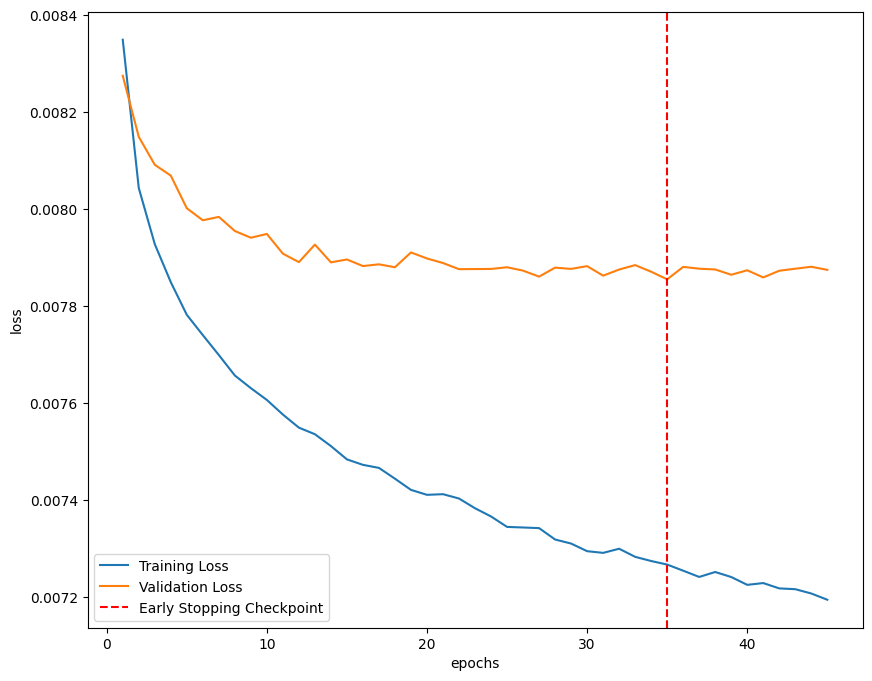

In [8]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(tr1_loss)+1),tr1_loss, label='Training Loss')
plt.plot(range(1,len(te1_loss)+1),te1_loss,label='Validation Loss')

# find position of lowest validation loss
minposs = te1_loss.index(min(te1_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [9]:
model = NeuralNetwork(hidden_size=100)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
early_stopper = EarlyStopper(patience=patience, min_delta=0)

tr2_loss, tr2_correct = [], []
te2_loss, te2_correct = [], []
for t in range(max_epochs):
    train_loss, train_correct = train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loss, test_correct = test_loop(test_dataloader, model, loss_fn)
    
    tr2_loss.append(train_loss), tr2_correct.append(train_correct)
    te2_loss.append(test_loss), te2_correct.append(test_correct)
    
    
    print(f"Epoch {t+1}: Train_accuracy: {(100*train_correct):>0.2f}%, Train_loss: {train_loss:>8f}, Test_accuracy: {(100*test_correct):>0.2f}%, Test_loss: {test_loss:>8f}")
    
    if early_stopper.early_stop(test_loss): 
        print("Done!")
        break

Epoch 1: Train_accuracy: 34.27%, Train_loss: 0.008285, Test_accuracy: 39.32%, Test_loss: 0.008259
Epoch 2: Train_accuracy: 41.82%, Train_loss: 0.007990, Test_accuracy: 42.81%, Test_loss: 0.008126
Epoch 3: Train_accuracy: 44.48%, Train_loss: 0.007887, Test_accuracy: 43.66%, Test_loss: 0.008077
Epoch 4: Train_accuracy: 46.65%, Train_loss: 0.007800, Test_accuracy: 44.37%, Test_loss: 0.008059
Epoch 5: Train_accuracy: 48.34%, Train_loss: 0.007739, Test_accuracy: 45.48%, Test_loss: 0.008004
Epoch 6: Train_accuracy: 49.73%, Train_loss: 0.007690, Test_accuracy: 47.28%, Test_loss: 0.007936
Epoch 7: Train_accuracy: 51.09%, Train_loss: 0.007635, Test_accuracy: 47.68%, Test_loss: 0.007917
Epoch 8: Train_accuracy: 52.30%, Train_loss: 0.007590, Test_accuracy: 47.26%, Test_loss: 0.007934
Epoch 9: Train_accuracy: 52.95%, Train_loss: 0.007565, Test_accuracy: 47.52%, Test_loss: 0.007910
Epoch 10: Train_accuracy: 53.78%, Train_loss: 0.007527, Test_accuracy: 49.25%, Test_loss: 0.007866
Epoch 11: Train_acc

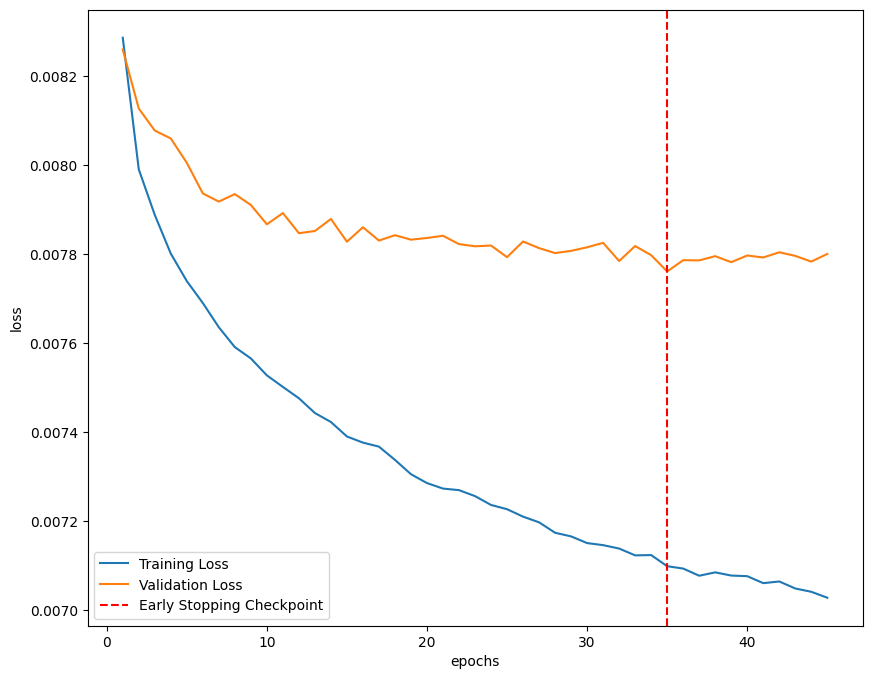

In [10]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(tr2_loss)+1),tr2_loss, label='Training Loss')
plt.plot(range(1,len(te2_loss)+1),te2_loss,label='Validation Loss')

# find position of lowest validation loss
minposs = te2_loss.index(min(te2_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [11]:
model = NeuralNetwork(hidden_size=500)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
early_stopper = EarlyStopper(patience=patience, min_delta=0)

tr3_loss, tr3_correct = [], []
te3_loss, te3_correct = [], []
for t in range(max_epochs):
    train_loss, train_correct = train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loss, test_correct = test_loop(test_dataloader, model, loss_fn)
    
    tr3_loss.append(train_loss), tr3_correct.append(train_correct)
    te3_loss.append(test_loss), te3_correct.append(test_correct)
    
    
    print(f"Epoch {t+1}: Train_accuracy: {(100*train_correct):>0.2f}%, Train_loss: {train_loss:>8f}, Test_accuracy: {(100*test_correct):>0.2f}%, Test_loss: {test_loss:>8f}")
    
    if early_stopper.early_stop(test_loss): 
        print("Done!")
        break

Epoch 1: Train_accuracy: 33.52%, Train_loss: 0.008304, Test_accuracy: 36.52%, Test_loss: 0.008365
Epoch 2: Train_accuracy: 38.23%, Train_loss: 0.008126, Test_accuracy: 40.41%, Test_loss: 0.008227
Epoch 3: Train_accuracy: 41.12%, Train_loss: 0.008018, Test_accuracy: 41.20%, Test_loss: 0.008197
Epoch 4: Train_accuracy: 41.23%, Train_loss: 0.008018, Test_accuracy: 42.45%, Test_loss: 0.008156
Epoch 5: Train_accuracy: 42.12%, Train_loss: 0.007985, Test_accuracy: 41.32%, Test_loss: 0.008182
Epoch 6: Train_accuracy: 43.14%, Train_loss: 0.007945, Test_accuracy: 42.75%, Test_loss: 0.008141
Epoch 7: Train_accuracy: 43.28%, Train_loss: 0.007943, Test_accuracy: 41.62%, Test_loss: 0.008192
Epoch 8: Train_accuracy: 41.97%, Train_loss: 0.007997, Test_accuracy: 40.97%, Test_loss: 0.008212
Epoch 9: Train_accuracy: 42.01%, Train_loss: 0.007995, Test_accuracy: 41.25%, Test_loss: 0.008200
Epoch 10: Train_accuracy: 42.00%, Train_loss: 0.007995, Test_accuracy: 38.49%, Test_loss: 0.008314
Epoch 11: Train_acc

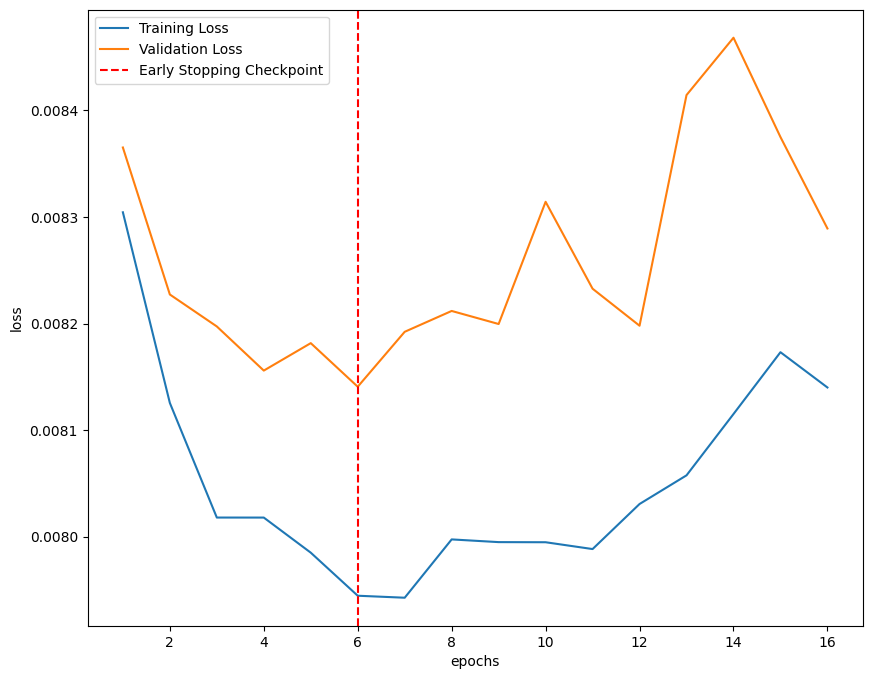

In [12]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(tr3_loss)+1),tr3_loss, label='Training Loss')
plt.plot(range(1,len(te3_loss)+1),te3_loss,label='Validation Loss')

# find position of lowest validation loss
minposs = te3_loss.index(min(te3_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

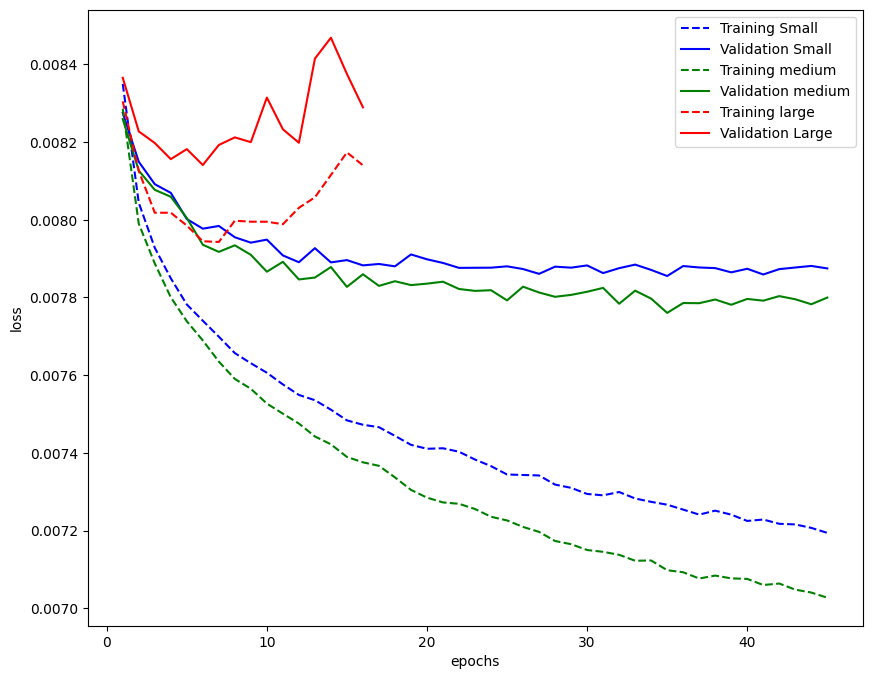

In [13]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(tr1_loss)+1),tr1_loss, linestyle = '--', color = 'b', label='Training Small')
plt.plot(range(1,len(te1_loss)+1),te1_loss, color = 'b', label='Validation Small')
plt.plot(range(1,len(tr2_loss)+1),tr2_loss, linestyle = '--', color = 'g', label='Training medium')
plt.plot(range(1,len(te2_loss)+1),te2_loss, color = 'g', label='Validation medium')
plt.plot(range(1,len(tr3_loss)+1),tr3_loss, linestyle = '--', color = 'r', label='Training large')
plt.plot(range(1,len(te3_loss)+1),te3_loss, color = 'r', label='Validation Large')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()